In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def create_graph_bar(df, col_x, col_y, x_label, y_label, title):
        plt.figure(figsize=(15, 6))
        aux = sns.barplot(x=col_x, y=col_y, data=df)
        aux.set(xlabel=x_label, ylabel=y_label)
        plt.title(title)

        for index, row in df.iterrows():
            aux.text(row.name, row[col_y], row[col_y], color='black', ha="center", fontsize=12)
        plt.savefig(f"imgs/{title}.png", dpi=300, bbox_inches='tight')

        plt.show()

In [3]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) + 1e-8
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denominator)

In [4]:
def preditc_vendas(df_sem_rup, df_com_rup):
    mediana_por_grupo = df_sem_rup.groupby(['key_loja', 'cod_produto'])['qtd_vendas'].median().reset_index()
    mediana_por_grupo.rename(columns={'qtd_vendas':'qtd_vendas_pred'}, inplace=True)

    df_sem_rup_pred = df_sem_rup.merge(mediana_por_grupo, on=['key_loja', 'cod_produto'], how='left')
    df_sem_rup_pred.fillna(value={'qtd_vendas_pred':0},inplace=True)

    df_com_rup_pred = df_com_rup.merge(mediana_por_grupo, on=['key_loja', 'cod_produto'], how='left')
    df_com_rup_pred.fillna(value={'qtd_vendas_pred':0},inplace=True)

    mae_baseline = mean_absolute_error(df_sem_rup_pred['qtd_vendas'], df_sem_rup_pred['qtd_vendas_pred'])
    smape_baseline = smape(df_sem_rup_pred['qtd_vendas'], df_sem_rup_pred['qtd_vendas_pred'])
    print(f"MAE do baseline Teste: {mae_baseline:.2f} | SMAPE baseline Teste: {smape_baseline:.2f}")

    return df_com_rup_pred

In [5]:
def generate_predict(tipo_demanda):
    df = pd.read_csv(f'../../data/processed/dados_features_{tipo_demanda}.csv')
    df['dt_estoque'] = pd.to_datetime(df['dt_estoque'])
    df_sem_rup = df[df['is_ruptura']==0]
    df_com_rup = df[df['is_ruptura']==1]

    df_com_rup_pred = preditc_vendas(df_sem_rup, df_com_rup)

    return df_com_rup_pred[['key_loja', 'cod_produto', 'dt_estoque', 'qtd_vendas_pred']]

# Smooth

In [6]:
df_com_rup_pred_smooth = generate_predict('Smooth')
df_com_rup_pred_smooth.head()

MAE do baseline Teste: 2.89 | SMAPE baseline Teste: 101.96


,key_loja,cod_produto,dt_estoque,qtd_vendas_pred
0,1,49897,2024-01-01,1.0
1,1,49898,2024-01-01,1.0
2,1,49943,2024-01-01,0.0
3,1,53510,2024-01-01,0.0
4,1,77684,2024-01-01,1.0


# Erratic

In [7]:
df_com_rup_pred_erratic = generate_predict('Erratic')
df_com_rup_pred_erratic.head()

MAE do baseline Teste: 1.73 | SMAPE baseline Teste: 100.59


,key_loja,cod_produto,dt_estoque,qtd_vendas_pred
0,1,49881,2024-01-01,0.0
1,2,48675,2024-01-01,0.0
2,2,49883,2024-01-01,0.0
3,3,49881,2024-01-01,1.0
4,4,49825,2024-01-01,0.0


# Intermittent

In [8]:
df_com_rup_pred_intermittent = generate_predict('Intermittent')
df_com_rup_pred_intermittent.head()

MAE do baseline Teste: 0.52 | SMAPE baseline Teste: 72.39


,key_loja,cod_produto,dt_estoque,qtd_vendas_pred
0,8,49880,2024-01-01,0.0
1,8,49880,2024-01-02,0.0
2,8,49880,2024-01-03,0.0
3,8,49880,2024-01-04,0.0
4,8,49880,2024-01-05,0.0


# Lumpy

In [9]:
df_com_rup_pred_lumpy = generate_predict('Lumpy')
df_com_rup_pred_lumpy.head()

MAE do baseline Teste: 0.56 | SMAPE baseline Teste: 61.95


,key_loja,cod_produto,dt_estoque,qtd_vendas_pred
0,1,49883,2024-01-01,0.0
1,1,49893,2024-01-01,0.0
2,2,49887,2024-01-01,0.0
3,2,49893,2024-01-01,0.0
4,2,49943,2024-01-01,0.0


# Sem Tipo

In [10]:
df_com_rup_pred_sem_tipo = generate_predict('Sem_Tipo')
df_com_rup_pred_sem_tipo.head()

MAE do baseline Teste: 0.19 | SMAPE baseline Teste: 26.89


,key_loja,cod_produto,dt_estoque,qtd_vendas_pred
0,1,22230,2024-01-01,0.0
1,1,25472,2024-01-01,1.0
2,1,25475,2024-01-01,1.0
3,1,48352,2024-01-01,0.0
4,1,49823,2024-01-01,0.0


# Consolidando

In [11]:
df_similares = pd.read_csv('../../data/raw/tb_similares.csv')
df_similares.rename(columns={"cod_material": "cod_produto"}, inplace=True)
df_similares.head()

,cod_produto,cod_material_recom,ranking
0,48635,25472,1
1,50651,74932,1
2,48062,77684,1
3,49893,48730,1
4,49943,84203,1


In [12]:
df_vendas = pd.read_csv('../../data/processed/df_vendas_consolidado.csv')
df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'])
df_vendas.head()

,dt_venda,key_loja,cod_produto,qtd_vendas,vlr_venda_tabelado_mean,vlr_desconto_mean,categoria_produto,sub_categoria_produto,linha_produto
0,2024-01-02,1,48062,1,284.70,0.0,217.0,422944,306420
1,2024-01-02,1,48635,1,419.70,0.0,955075.0,483679,284036
2,2024-01-02,1,82060,1,1017.00,191.1,157293.0,483679,120030
3,2024-01-02,2,1650,1,167.70,36.0,217.0,422944,731659
4,2024-01-02,2,48060,2,584.55,0.0,217.0,422944,306420


In [13]:
df_venda_similares = df_similares.merge(df_vendas, left_on=['cod_material_recom'], right_on=['cod_produto'], how='left')
df_venda_similares.drop(columns=['cod_produto_y'], inplace=True)
df_venda_similares.rename(columns={'cod_produto_x':'cod_produto'}, inplace=True)

df_venda_similares = df_venda_similares[['cod_produto', 'cod_material_recom', 'ranking', 'dt_venda', 'key_loja', 'qtd_vendas']]
df_venda_similares_total = df_venda_similares.groupby(['dt_venda', 'key_loja', 'cod_produto'],as_index=False)['qtd_vendas'].sum()
df_venda_similares_total.rename(columns={'qtd_vendas':'qtd_vendas_similar'}, inplace=True)

df_venda_similares_total.head()

,dt_venda,key_loja,cod_produto,qtd_vendas_similar
0,2024-01-02,1.0,48060,1.0
1,2024-01-02,1.0,74722,1.0
2,2024-01-02,2.0,1428,2.0
3,2024-01-02,2.0,48062,2.0
4,2024-01-02,2.0,48672,1.0


In [14]:
df_rup_pred = pd.concat([df_com_rup_pred_smooth, df_com_rup_pred_erratic, df_com_rup_pred_intermittent, df_com_rup_pred_lumpy, df_com_rup_pred_sem_tipo])
df_rup_pred.head()

,key_loja,cod_produto,dt_estoque,qtd_vendas_pred
0,1,49897,2024-01-01,1.0
1,1,49898,2024-01-01,1.0
2,1,49943,2024-01-01,0.0
3,1,53510,2024-01-01,0.0
4,1,77684,2024-01-01,1.0


In [15]:
df_rup_pred_vs = df_rup_pred.merge(df_venda_similares_total, left_on=['dt_estoque','key_loja','cod_produto'], right_on=['dt_venda','key_loja','cod_produto'], how='left')
df_rup_pred_vs.fillna(value={'qtd_vendas_similar':0}, inplace=True)
df_rup_pred_vs['diff_qtd_vendas'] = df_rup_pred_vs['qtd_vendas_pred'] - df_rup_pred_vs['qtd_vendas_similar']
df_rup_pred_vs.head()

,key_loja,cod_produto,dt_estoque,qtd_vendas_pred,dt_venda,qtd_vendas_similar,diff_qtd_vendas
0,1,49897,2024-01-01,1.0,NaT,0.0,1.0
1,1,49898,2024-01-01,1.0,NaT,0.0,1.0
2,1,49943,2024-01-01,0.0,NaT,0.0,0.0
3,1,53510,2024-01-01,0.0,NaT,0.0,0.0
4,1,77684,2024-01-01,1.0,NaT,0.0,1.0


In [16]:
total_vendas_pred = df_rup_pred_vs['qtd_vendas_pred'].sum().astype(int)
total_vendas_similares = df_rup_pred_vs['qtd_vendas_similar'].sum().astype(int)

df_result = pd.DataFrame({'flag':['QTD Vendas Perdidas', 'QTD Vendas Similares'],
                          'value':[total_vendas_pred, total_vendas_similares]
                         })

print(f'Total de Vendas se não tivesse em Ruptura: {total_vendas_pred} | Venda dos Similares durante Ruptura: {total_vendas_similares} (Diff:{total_vendas_pred - total_vendas_similares})')

Total de Vendas se não tivesse em Ruptura: 33140 | Venda dos Similares durante Ruptura: 19086 (Diff:14054)


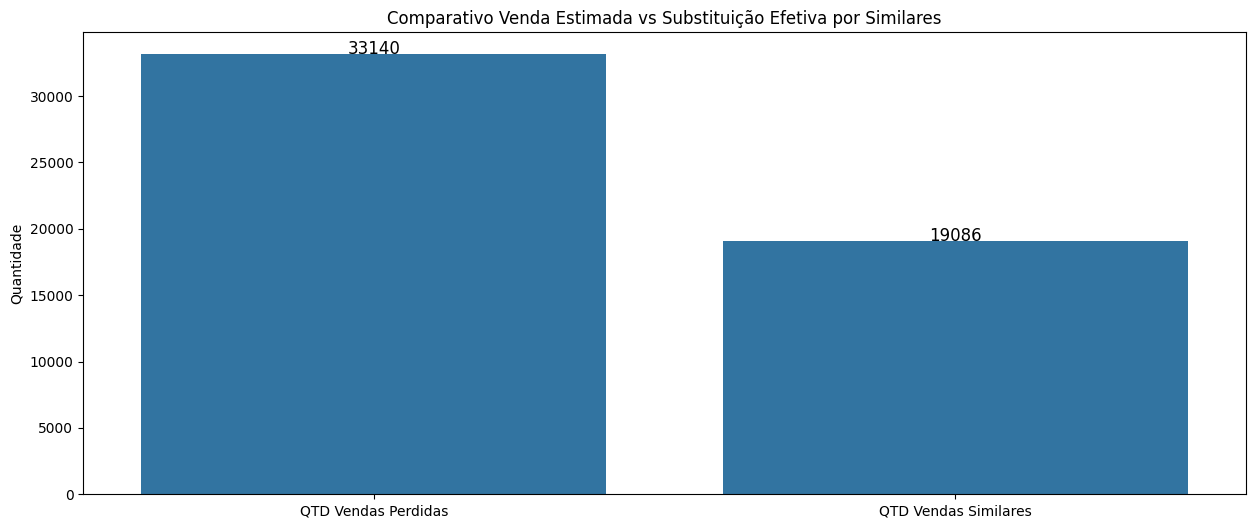

In [18]:
create_graph_bar(df_result, 'flag', 'value', '', 'Quantidade', f'Comparativo Venda Estimada vs Substituição Efetiva por Similares')